CSS - Final Project

In [2]:
import json, re, glob
import pandas as pd
import networkx as nx
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re
import glob, json, os
from tqdm import tqdm
import nltk
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
data_dir = "congresstweets-master/data"

print("Looking in:", data_dir)
print("Contents:", os.listdir(data_dir)[:5])

json_paths = glob.glob(os.path.join(data_dir, "*.json"))
print(f"Found {len(json_paths)} JSON files")

tweets = []
for path in tqdm(json_paths):
    with open(path, "r", encoding="utf-8") as f:
        tweets.extend(json.load(f))

df = pd.DataFrame(tweets)
print(f"Loaded {len(df)} tweets")
df.head()


Looking in: congresstweets-master/data
Contents: ['2017-06-21.json', '2017-06-22.json', '2017-06-23.json', '2017-06-24.json', '2017-06-25.json']
Found 2197 JSON files


100%|██████████| 2197/2197 [00:15<00:00, 144.00it/s]


Loaded 5068352 tweets


,id,screen_name,time,link,text,source,user_id,yesterday,today
0,877527850420776961,RepErikPaulsen,2017-06-21T10:05:17-04:00,https://www.twitter.com/CRN_Supplements/status...,RT @CRN_Supplements Thank you @RepErikPaulsen ...,Twitter Web Client,17513304,NaN,NaN
1,877628169028632576,RepTedBudd,2017-06-21T16:43:55-04:00,https://www.twitter.com/RepTedBudd/statuses/87...,Congrats to our Congressional Award Gold Medal...,Twitter Web Client,817138492614524928,NaN,NaN
2,877580122785685504,SenatorWicker,2017-06-21T13:33:00-04:00,https://www.twitter.com/SenatorWicker/statuses...,ICYMI: I chaired a hearing to explore expandin...,TweetDeck,264219447,NaN,NaN
3,877655119638048770,BernieSanders,2017-06-21T18:31:01-04:00,https://www.twitter.com/BernieSanders/statuses...,The Affordable Care Act should be improved. Bu...,TweetDeck,216776631,NaN,NaN
4,877632313550553089,RepDonBacon,2017-06-21T17:00:23-04:00,https://www.twitter.com/RepDonBacon/statuses/8...,#TaxReform will create a low tax rate just for...,Hootsuite,818975124460335106,NaN,NaN


In [4]:
# Create a metadata mapping to add to network later
# Downloaded from congresstweets-automator repo
meta_path = "congresstweets-automator-master\data\historical-users-filtered.json"

with open(meta_path, "r") as f:
    users = json.load(f)

# Build map: {screen_name: party}
party_map = {
    u['accounts'][0]["screen_name"].lower(): u.get("party", None)
    for u in users
    if "party" in u
}
chamber_map = {
    u['accounts'][0]["screen_name"].lower(): u.get("chamber", None)
    for u in users
    if "party" in u
}

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\gusta\AppData\Local\Temp\ipykernel_15936\924396558.py:3: SyntaxWarning: invalid escape sequence '\d'
  meta_path = "congresstweets-automator-master\data\historical-users-filtered.json"


In [5]:
def mention_context_sentiment(text, handle, window_size=10):
    """
    For each @handle in `text`, pull out up to `window_size` words
    before and after, run VADER on that slice, and average.
    """
    # Clean the handle
    handle_clean = handle.lower().lstrip('@')
    # Compile a regex that gets up to window_size words on each side, \S+ matches a "word"
    pattern = re.compile(
        rf'(?:\S+\s+){{0,{window_size}}}@{re.escape(handle_clean)}(?:\s+\S+){{0,{window_size}}}',
        flags=re.IGNORECASE
    )
    scores = []
    for m in pattern.finditer(text):
        ctx = m.group(0)
        scores.append(analyzer.polarity_scores(ctx)['compound'])
    return sum(scores) / len(scores) if scores else 0.0

In [6]:
SAMPLE_SIZE = 300_000
df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42).reset_index(drop=True)
print(f"Working on {len(df_sample):,} tweets (out of {len(df):,})")

mention_re = re.compile(r"@([A-Za-z0-9_]+)")

G = nx.DiGraph()
for screen_name, text in tqdm(zip(df_sample["screen_name"], df_sample["text"]), desc="Tweets processed", total = 300_000):
    mentions = set(m.lower() for m in mention_re.findall(text))
    src = screen_name.lower()
    for tgt in mentions:
        mention_sentiment = mention_context_sentiment(text, tgt)
        if tgt == src:
            continue
        if G.has_edge(src, tgt):
            G[src][tgt]["n_mentions"] += 1
            G[src][tgt]["avg_sentiment"] += mention_sentiment
        else:
            G.add_edge(src, tgt, n_mentions=1, avg_sentiment = mention_sentiment)

# Average sentiment values
for src, tgt in tqdm(G.edges(), desc='Averaging sentiments'): 
    G[src][tgt]['avg_sentiment'] = G[src][tgt]['avg_sentiment']/G[src][tgt]['n_mentions']
    
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
in_degs  = np.array([d for _, d in G.in_degree()])
out_degs = np.array([d for _, d in G.out_degree()])

print(f"Nodes: {num_nodes:,}")
print(f"Edges: {num_edges:,}")
print(f"In‑degree → mean: {in_degs.mean():.2f},  std: {in_degs.std():.2f}")
print(f"Out‑degree → mean: {out_degs.mean():.2f}, std: {out_degs.std():.2f}")

low_weight = [(u, v) for u, v, d in G.edges(data=True) if d["n_mentions"] < 3]
G.remove_edges_from(low_weight)
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

print(f"After pruning: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
in_degs  = np.array([d for _, d in G.in_degree()])
out_degs = np.array([d for _, d in G.out_degree()])
print(f"In‑degree → mean: {in_degs.mean():.2f},  std: {in_degs.std():.2f}")
print(f"Out‑degree → mean: {out_degs.mean():.2f}, std: {out_degs.std():.2f}")

Working on 300,000 tweets (out of 5,068,352)


Averaging sentiments: 100%|██████████| 177540/177540 [00:00<00:00, 1056364.56it/s]


Nodes: 57,043
Edges: 177,540
In‑degree → mean: 3.11,  std: 12.71
Out‑degree → mean: 3.11, std: 31.57
After pruning: 5,307 nodes, 17,773 edges
In‑degree → mean: 3.35,  std: 13.47
Out‑degree → mean: 3.35, std: 13.60


In [7]:
# Add metadata to network
nx.set_node_attributes(G, party_map, name="party")
nx.set_node_attributes(G, chamber_map, name="chamber")

In [8]:
from collections import Counter
counts = Counter(nx.get_node_attributes(G, "party").values())
print(counts)

Counter({'D': 287, 'R': 265, 'N/A': 2, 'I': 2, 'L': 1})


In [9]:
# Extract (source, target, avg_sentiment) for all edges
edge_data = [(u, v, data.get('avg_sentiment', 0.0)) for u, v, data in G.edges(data=True)]
sent_df = pd.DataFrame(edge_data, columns=['source', 'target', 'avg_sentiment'])

# Sort to get extremes
sent_df_sorted = sent_df.sort_values('avg_sentiment')
neg_df = sent_df_sorted.head(5).reset_index(drop=True)
pos_df = sent_df_sorted.tail(5).sort_values('avg_sentiment', ascending=False).reset_index(drop=True)

print('5 Most Negative Sentiment Edges\n', neg_df)
print('\n5 Most Positive Sentiment Edges\n', pos_df)

5 Most Negative Sentiment Edges
            source         target  avg_sentiment
0  senjeffmerkley      repnikema      -0.847700
1     repbonamici      senategop      -0.677333
2          repmgs  replucymcbath      -0.675367
3        randpaul     teamcavuto      -0.644867
4  ayannapressley      booker4ky      -0.607250

5 Most Positive Sentiment Edges
            source          target  avg_sentiment
0     reelecthank  meredadjohnson       0.902425
1   grassleyworks     senatordole       0.894800
2  repstephmurphy        bjoewolf       0.885967
3  repbuddycarter      whitehouse       0.880300
4     roslehtinen         iflymia       0.875633


In [10]:
sent_series = df_sample["text"].apply(analyzer.polarity_scores).apply(pd.Series)
df_sample = pd.concat([df_sample, sent_series], axis=1)


user_stats = (
    df_sample
    .groupby("screen_name")["compound"]
    .agg(["mean","median","std","count"])
    .reset_index()
)

user_stats.columns = [
    "screen_name",
    "avg_compound",
    "med_compound",
    "std_compound",
    "n_tweets"
]

print("Sample of per‐user sentiment stats:")
print(user_stats.head())


mapping_avg   = dict(zip(user_stats["screen_name"].str.lower(), user_stats["avg_compound"]))
mapping_count = dict(zip(user_stats["screen_name"].str.lower(), user_stats["n_tweets"]))

nx.set_node_attributes(G, mapping_avg,   "avg_sentiment_account")
nx.set_node_attributes(G, mapping_count, "n_tweets")

top5 = user_stats.nlargest(5, "avg_compound")[["screen_name","avg_compound","n_tweets"]]
bot5 = user_stats.nsmallest(5, "avg_compound")[["screen_name","avg_compound","n_tweets"]]
print("\nTop 5 happiest accounts:\n", top5.to_string(index=False))
print("\nTop 5 saddest accounts:\n", bot5.to_string(index=False))

Sample of per‐user sentiment stats:
    screen_name  avg_compound  med_compound  std_compound  n_tweets
0   ABrindisiNY      0.355063        0.4146      0.537782        24
1  ANTHONYDESPO      0.545026        0.7579      0.512104        47
2           AOC      0.191577        0.2732      0.575955       501
3   ASEANCaucus      0.146800        0.0000      0.254265         3
4    AaronPBean      0.856000        0.8979      0.124767         5

Top 5 happiest accounts:
     screen_name  avg_compound  n_tweets
   pettersen4co      0.984700         1
  JohnnyIsakson      0.966700         1
   congpeteking      0.953800         1
Duarte4Congress      0.944900         1
     DonDavisNC      0.934567         6

Top 5 saddest accounts:
    screen_name  avg_compound  n_tweets
   votetimmons     -0.850600         2
 MacThornberry     -0.598767         3
  TeamJeffries     -0.510600         1
MorganMcGarvey     -0.486300         2
      EdRRoyce     -0.463733         3


In [11]:
# Color nodes based on average sentiment
color_map = {
    'negative': '#d62728',   # red
    'neutral':  '#7f7f7f',   # gray
    'positive': '#2ca02c'    # green
}
for k, v in G.nodes(data=True):
    if v:
        avg_sentiment = v['avg_sentiment_account']
    else: avg_sentiment = 0
    v['group'] = color_map['positive'] if avg_sentiment > 0.1 else color_map['negative'] if avg_sentiment < -0.1 else color_map['neutral']

KeyError: 'avg_sentiment_account'

In [12]:
# Color nodes based on political party
color_map = {
    'D': '#0078ff',    # Blue
    'R':  '#ff0000',   # Red
    'I': '#ecff00',   # Purple
    'L': '#4dff00',   # Green
    'N/A': '#7f7f7f'  # Grey
    
}
for k, v in G.nodes(data=True):
    if v:
        try:
            party = v['party']
        except: party = 'N/A'
    else: party = 'N/A'
    v['group'] = color_map[party]

In [13]:
def get_deg_assortativity_coef(G):
    degrees = dict(G.degree())
    N = len(G.edges())

    same_deg = 0
    for (i, j) in list(G.edges()): # Compute total amount of edges between nodes of equal degree
        if degrees[i] == degrees[j]:
            same_deg += 1/N

    degs = np.array(list(degrees.values()))
    exp_same_deg = 0
    total_half_stubs = sum(degs)
    for deg in set(degs): # Compute expected number of edges between nodes of same degree 
        n_deg = len(degs[degs == deg])
        n_half_stubs = n_deg*deg
        exp_same_deg += (n_half_stubs/total_half_stubs)**2

    r = (same_deg - exp_same_deg)/(1-exp_same_deg)
    return r

In [14]:
get_deg_assortativity_coef(G)

np.float64(-0.011236782259231658)

In [17]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import netwulf

network_properties, config = netwulf.visualize(G, plot_in_cell_below=False)
print('got data')

for link in network_properties['links']:
    src = link['source']   
    tgt = link['target'] 
    # Add avg sentiment back to link
    link['avg_sentiment'] = G[src][tgt]['avg_sentiment']

sents = [d['avg_sentiment'] for _,_,d in G.edges(data=True)]
cmap = cm.get_cmap('RdYlGn')
norm = mcolors.Normalize(vmin=min(sents), vmax=max(sents))

for link in network_properties['links']:
    s = link.get('avg_sentiment')
    rgba = cmap(norm(s))
    link['color'] = mcolors.to_hex(rgba)

# now instruct Netwulf to use your manual hexes
config['link_color_field'] = 'color'
# graph_data, config = netwulf.visualize(network_properties, config = config)

C:\Users\gusta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


got data


C:\Users\gusta\AppData\Local\Temp\ipykernel_15936\1779668827.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')


C:\Users\gusta\AppData\Local\Temp\ipykernel_15936\729509020.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


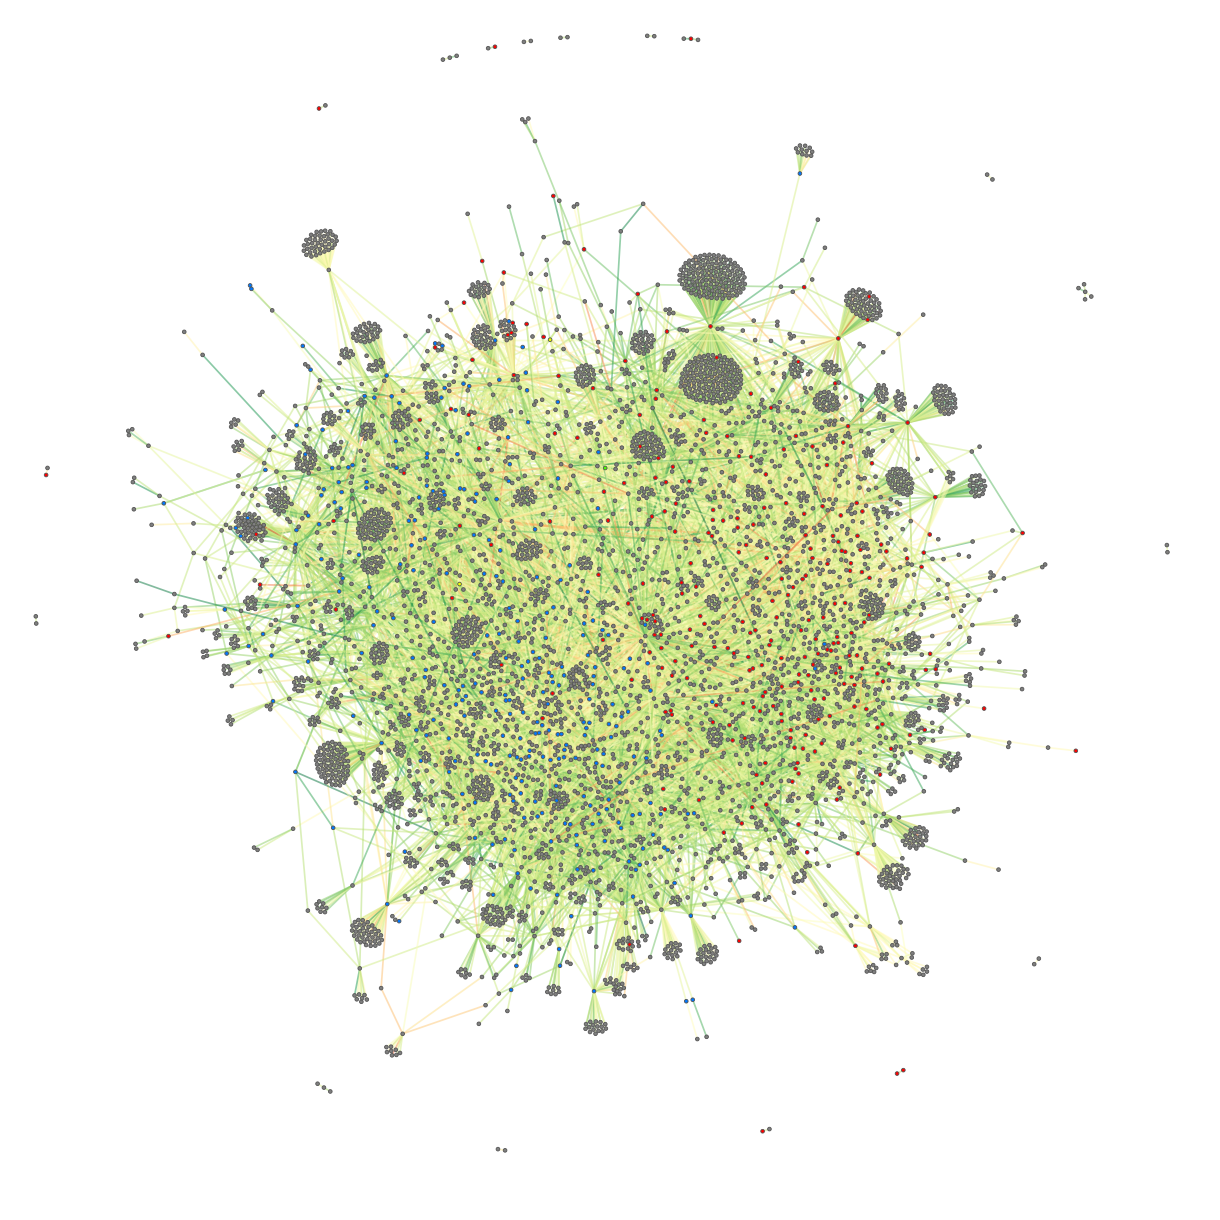

In [18]:
from netwulf.tools import draw_netwulf

# Draw colored edges, which doesn't work in interactive mode
fig, ax = draw_netwulf(network_properties, figsize=12)
fig.show()

In [19]:
# Get only congress members graph
only_party_G = G.copy()
no_party = [k for k,v in G.nodes(data=True) if v.get("party") is None]
only_party_G.remove_nodes_from(no_party)
only_party_G = nx.DiGraph(only_party_G)
# Remove isolated nodes
isolated_nodes = list(nx.isolates(only_party_G))
only_party_G.remove_nodes_from(isolated_nodes)

In [20]:
network_properties, config = netwulf.visualize(only_party_G, plot_in_cell_below=False)
print('got data')

for link in network_properties['links']:
    src = link['source']   
    tgt = link['target'] 
    # Add avg sentiment back to link
    link['avg_sentiment'] = only_party_G[src][tgt]['avg_sentiment']

sents = [d['avg_sentiment'] for _,_,d in only_party_G.edges(data=True)]
cmap = cm.get_cmap('RdYlGn')
norm = mcolors.Normalize(vmin=min(sents), vmax=max(sents))

for link in network_properties['links']:
    s = link.get('avg_sentiment')
    rgba = cmap(norm(s))
    link['color'] = mcolors.to_hex(rgba)

# now instruct Netwulf to use your manual hexes
config['link_color_field'] = 'color'
# graph_data, config = netwulf.visualize(network_properties, config = config)

C:\Users\gusta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


got data


C:\Users\gusta\AppData\Local\Temp\ipykernel_15936\3246093713.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')


C:\Users\gusta\AppData\Local\Temp\ipykernel_15936\729509020.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


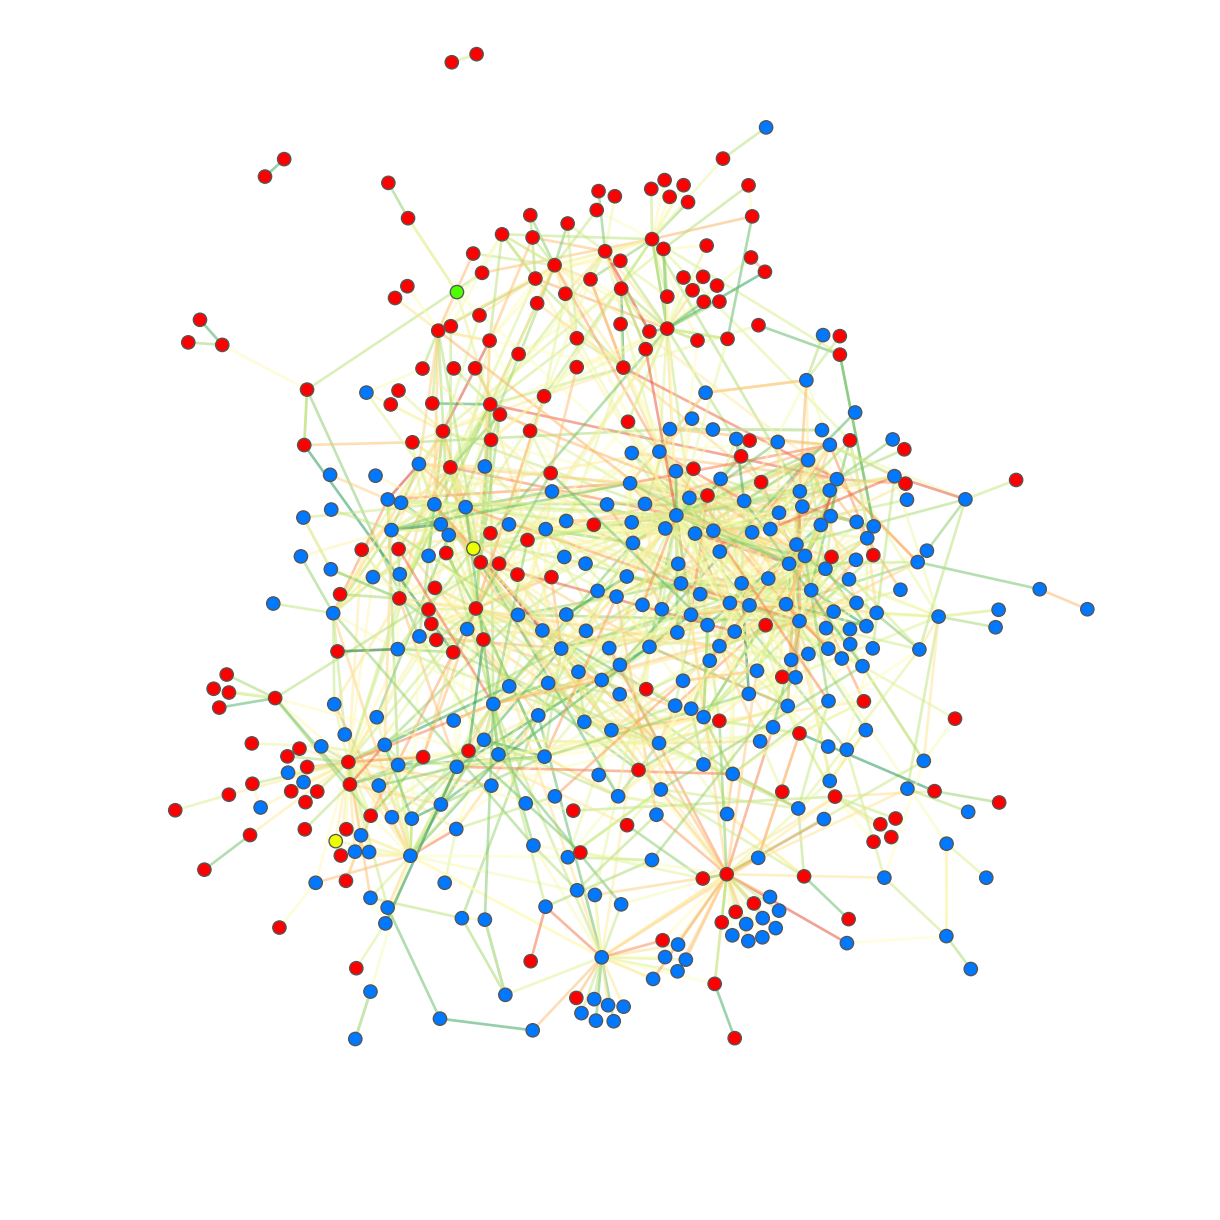

In [21]:
from netwulf.tools import draw_netwulf

# Draw colored edges, which doesn't work in interactive mode
fig, ax = draw_netwulf(network_properties, figsize=12)
fig.show()

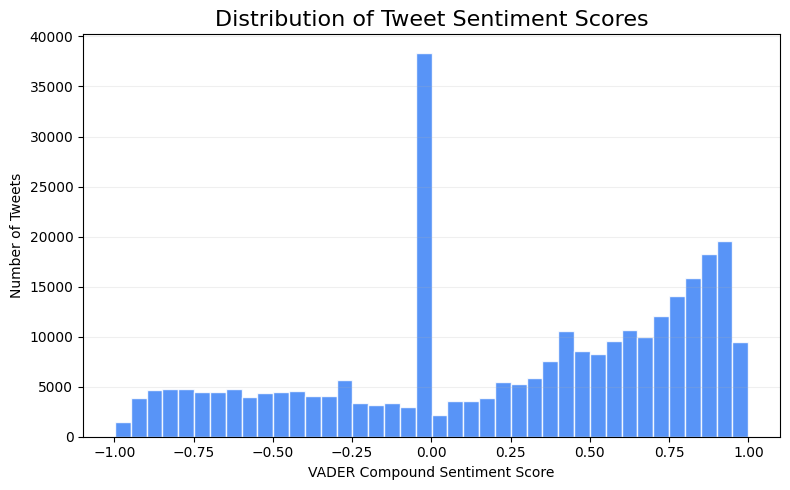

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_sample['compound'], bins=40, color='#3b82f6', edgecolor='white', alpha=0.85)
plt.title('Distribution of Tweet Sentiment Scores', fontsize=16)
plt.xlabel('VADER Compound Sentiment Score')
plt.ylabel('Number of Tweets')
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

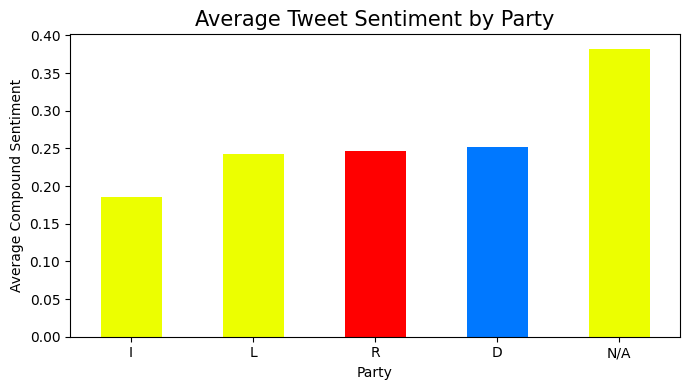

In [24]:
party_sent = (
    df_sample.assign(party=df_sample['screen_name'].str.lower().map(party_map))
    .groupby('party')['compound']
    .mean()
    .sort_values()
)

plt.figure(figsize=(7,4))
party_sent.plot(kind='bar', color=['#0078ff' if p=='D' else '#ff0000' if p=='R' else '#ecff00' for p in party_sent.index])
plt.title('Average Tweet Sentiment by Party', fontsize=15)
plt.ylabel('Average Compound Sentiment')
plt.xlabel('Party')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

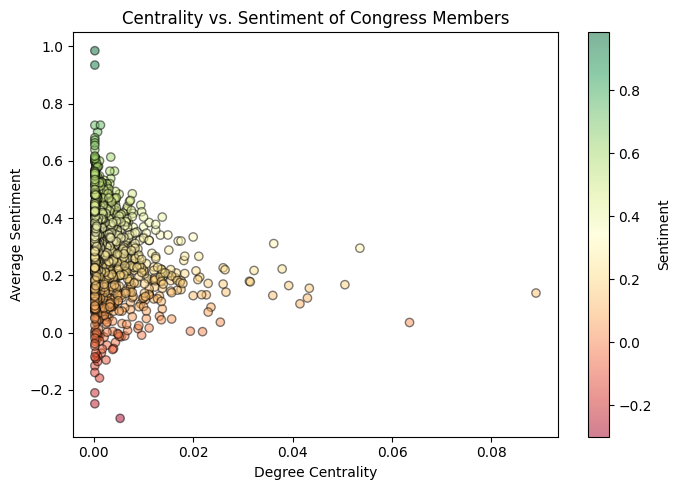

In [27]:
centrality = nx.degree_centrality(G)
sentiment = nx.get_node_attributes(G, 'avg_sentiment_account')

x = []
y = []
for node in G.nodes():
    if node in sentiment:
        x.append(centrality[node])
        y.append(sentiment[node])

plt.figure(figsize=(7,5))
plt.scatter(x, y, alpha=0.5, c=y, cmap='RdYlGn', edgecolor='k')
plt.xlabel('Degree Centrality')
plt.ylabel('Average Sentiment')
plt.title('Centrality vs. Sentiment of Congress Members')
plt.colorbar(label='Sentiment')
plt.tight_layout()
plt.show()